In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score,auc
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import RandomOverSampler
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeRandomOverSamples(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original training set shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    ros = RandomOverSampler(random_state=123)
    X_train, Y_train_labelled = ros.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [5]:
image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [7]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [8]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


# Evaluation: Utility Functions

In [9]:
# onehot encoded Y_all
def kFold_train(X_all,Y_all, mode_version):
    from sklearn.model_selection import StratifiedKFold
    n_split=10
    n_classes=8

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]

    count = 1

    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
        x_train,x_test=X_all[train_index],X_all[test_index]
        y_train,y_test=Y_all[train_index],Y_all[test_index]
        
        
       
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
        x_train, y_train= makeRandomOverSamples(x_train, y_train)

        # create and fit the model
        cv_model=build_current_model() # lr,dense,cnn
        history = cv_model.fit(x_train, y_train,
                  batch_size=8,
                  epochs=100,
                  validation_data= (x_val, y_val),
                  verbose=2,
                  callbacks=my_callbacks)


        file_name = mode_version +'_iter_' +str(count)
        
        
                
        #store test index
#         csv_name= mode_version +'_testset_iter_' +str(count)
#         test_index_df = pd.DataFrame(data=test_index,columns=["test_index"])
#         with open(csv_name, mode='w') as f:
#                  test_index_df.to_csv(f)
        #Store History
        hist_df = pd.DataFrame(history.history) 
        hist_json_file = file_name + '.json'

        with open(hist_json_file, mode='w') as f:
            hist_df.to_json(f)
            
            

        model_file = file_name + '.model'
        print(model_file)

        #Save Model
        cv_model.save(model_file) #Save the model

        count+=1

In [25]:
def kFold_test(X_all,Y_all, mode_version):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
    from sklearn.metrics import confusion_matrix

    n_split=10
    n_classes=8

    all_base_precision = list()
    all_base_recall = list()
    all_macro_precision = list()
    all_macro_recall = list()
    all_f1 = list()
    all_macro_f1 = list()

    all_tpr = list()
    all_fpr = list()
    all_precision = list()
    all_recall = list()
    all_cm=list()
    all_accuracy = list()

    all_df = list()

    y_all_labelled=[]
    for i in range(len(Y_all)):
            y_all_labelled.append(np.argmax(Y_all[i]))

    count = 1


    for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
        # use the index to generate training an testing sets
        x_train,x_test=X_all[train_index],X_all[test_index]
        y_train,y_test=Y_all[train_index],Y_all[test_index]


        file_name = mode_version +'_iter_' +str(count)
#         csv_name= mode_version +'_testset_iter_' +str(count)
        #Load History 
        hist_json_file = file_name + '.json'
        history_info = pd.read_json(hist_json_file)
        all_df.append(history_info)


        # Load Model
        model_file = file_name + '.model'
        print('File Name Loaded: ',model_file)
        cv_model = tf.keras.models.load_model(model_file) 
        
#         #load test set 
#         testset_file= csv_name
#         testset_df= pd.read_csv (testset_file)
#         test_index=testset_df["test_index"].to_numpy()
       
#         x_test=X_all[test_index]
#         y_test=Y_all[test_index]


        count+=1

        #generate predictions
        y_pred = cv_model.predict(x_test)
        actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)

        #calc metrics
        curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
        curr_macro_prec = precision_score(actual, predicted,average='macro')
        curr_macro_rec = recall_score(actual, predicted,average='macro')
        curr_macro_f1 = f1_score(actual, predicted,average='macro')

        actual_labeled = list()
        predict_labeled = list()
        for x,y in zip(actual,predicted):
            actual_labeled.append(getSpecies(x))
            predict_labeled.append(getSpecies(y))

        labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)

        curr_fpr = [0] * n_classes
        curr_tpr = [0] * n_classes
        for i in range(n_classes):
            curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])

        curr_prec = [0] * n_classes
        curr_rec = [0] * n_classes
        for i in range(n_classes):
            curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])


        curr_accuracy = accuracy_score(actual, predicted)

        #add to lists
        all_base_precision.append(curr_base_prec)
        all_base_recall.append(curr_base_rec)
        all_macro_precision.append(curr_macro_prec)
        all_macro_recall.append(curr_macro_rec)

        all_f1.append(curr_f1)
        all_macro_f1.append(curr_macro_f1)

        all_accuracy.append(curr_accuracy)


        all_fpr.append(curr_fpr)
        all_tpr.append(curr_tpr)
        all_precision.append(curr_prec)
        all_recall.append(curr_rec)
        all_cm.append(curr_cm)
    kFold_metrics={
            "all_base_precision": all_base_precision ,
            "all_base_recall": all_base_recall,
            "all_macro_precision":all_macro_precision ,
            "all_macro_recall":all_macro_recall ,
            "all_f1":all_f1,
            "all_macro_f1":all_macro_f1 ,
        
            "all_accuracy":all_accuracy ,
            "all_fpr":all_fpr,
            "all_tpr": all_tpr,
            "all_precision":all_precision,
            "all_recall":all_recall,
            "all_cm": all_cm,
            "all_df":all_df
            
        }
    return kFold_metrics




In [11]:
def plot_loss_Accuracy(all_df):
    for df in all_df:
        _, axs = plt.subplots(ncols=2)

        sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
        sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

        sns.lineplot(data=df['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
        sns.lineplot(data=df['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [12]:
def print_metrics(KFold_metrics):
    print('precision mean by class', np.array(KFold_metrics.get("all_base_precision")).mean(axis=0))
    print('precision sdev by class', np.array(KFold_metrics.get("all_base_precision")).std(axis=0))

    print('macro precision mean', np.array(KFold_metrics.get("all_macro_precision")).mean())
    print('macro precision sdev', np.array(KFold_metrics.get("all_macro_precision")).std())


    print('recall mean', np.array(KFold_metrics.get("all_base_recall")).mean(axis=0))
    print('recall sdev', np.array(KFold_metrics.get("all_base_recall")).std(axis=0))

    print('macro recall mean', np.array(KFold_metrics.get("all_macro_recall")).mean())
    print('macro recall sdev', np.array(KFold_metrics.get("all_macro_recall")).std())

    print('f1 mean', np.array(KFold_metrics.get("all_f1")).mean(axis=0))
    print('f1 sdev', np.array(KFold_metrics.get("all_f1")).std(axis=0))

    print('macro f1 mean', np.array(KFold_metrics.get("all_macro_f1")).mean())
    print('macro f1 sdev', np.array(KFold_metrics.get("all_macro_f1")).std())

    print('accuracy mean', np.array(KFold_metrics.get("all_accuracy")).mean())
    print('accuracy sdev', np.array(KFold_metrics.get("all_accuracy")).std())



In [13]:
# Plot all K-Fold ROC curves
def plot_ROC(all_fpr,all_tpr,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            auc_val = np.around(auc_val,4)
            sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')


In [14]:
def print_meanAUC(all_fpr,all_tpr,n_split=10, n_classes=8):
    aucs = list()

    for i in range(n_classes):
        aucs.append(list())


    for i in range(n_split):
        for j in range(n_classes):
            auc_val = auc(all_fpr[i][j], all_tpr[i][j])
            aucs[j].append(auc_val)

    for i in range(n_classes):
        print("Sp: ", getSpecies(i))
        print("AUC Mean ", np.array(aucs[i]).mean())
        print("Std ", np.array(aucs[i]).std())

In [15]:
#Plot all K-Fold Precision/Recall curves
def plot_precision_recall(all_recall,all_precision,n_split=10, n_classes=8):
    for i in range(n_split):
        _, axs = plt.subplots(ncols=1)
        axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
        for j in range(n_classes):
            sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

In [16]:
def plot_confusion_matrices_per_iter(all_cm,n_split=10, n_classes=8):
    ## Plot all K-Fold confusion matrices
    import numpy as np
    import matplotlib.pylab as pl
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    # Create 1X 5 sub plots
    # gs = gridspec.GridSpec(1,n_split)
    figs=[]
    for i in range(n_split):
        figs.append(plt.figure())

    for i in range(n_split):
        print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
        print(all_cm[i])
        print("\n")

        ax=figs[i].add_subplot()
        sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells


        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
        ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [17]:
def  plot_macro_confusion_matrices(all_cm,n_split=10, n_classes=8):
    ## plot macro cm
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        
    sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
    for i in range(n_split):
        sum_all_cm+=all_cm[i]


    #plot 
    figs=[]
    for i in range(2):
        figs.append(plt.figure())

    print("sum of all confuion matrices\n",sum_all_cm)
    ax=figs[0].add_subplot()
    sns.heatmap(sum_all_cm, annot=True, ax = ax);

    avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
    print("\naverage of all confuion matrices\n",avg_all_cm)
    ax=figs[1].add_subplot()
    sns.heatmap(avg_all_cm, annot=True, ax = ax);
    return sum_all_cm, avg_all_cm

In [18]:
 def plot_normalised_confusion_matrix( sum_all_cm, avg_all_cm, n_split=10, n_classes=8):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
        

    cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
    cm = (np.around(cm,2))
    print(cm)


    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

### Load and Evaluate



## V1 !!!!! K-Fold Training and Evaluation


In [19]:
folder = "models"
mode_version = "spec_RO_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/spec_RO_v1


In [20]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=16,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(96)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(32)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [21]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 16)        2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 56, 85, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 16)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 16)        0         
_________

In [23]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 7s - loss: 1.8577 - acc: 0.2861 - val_loss: 1.2109 - val_acc: 0.5404
Epoch 2/100
9592/9592 - 7s - loss: 1.4359 - acc: 0.4716 - val_loss: 1.7413 - val_acc: 0.2261
Epoch 3/100
9592/9592 - 7s - loss: 1.0377 - acc: 0.6402 - val_loss: 1.0090 - val_acc: 0.6103
Epoch 4/100
9592/9592 - 7s - loss: 0.8122 - acc: 0.7222 - val_loss: 1.1397 - val_acc: 0.5643
Epoch 5/100
9592/9592 - 7s - loss: 0.6725 - acc: 0.7754 - val_loss: 0.5724 - val_acc: 0.7610
E

Epoch 41/100
9592/9592 - 8s - loss: 0.1189 - acc: 0.9640 - val_loss: 0.2973 - val_acc: 0.9099
Epoch 42/100
9592/9592 - 9s - loss: 0.1196 - acc: 0.9600 - val_loss: 0.3483 - val_acc: 0.8897
Epoch 43/100
9592/9592 - 8s - loss: 0.0995 - acc: 0.9677 - val_loss: 0.1636 - val_acc: 0.9504
Epoch 44/100
9592/9592 - 9s - loss: 0.1081 - acc: 0.9655 - val_loss: 0.2485 - val_acc: 0.9283
Epoch 45/100
9592/9592 - 9s - loss: 0.1039 - acc: 0.9665 - val_loss: 0.2530 - val_acc: 0.9338
Epoch 46/100
9592/9592 - 9s - loss: 0.1110 - acc: 0.9683 - val_loss: 0.1906 - val_acc: 0.9357
Epoch 47/100
9592/9592 - 9s - loss: 0.1041 - acc: 0.9685 - val_loss: 0.1464 - val_acc: 0.9559
Epoch 48/100
9592/9592 - 8s - loss: 0.1084 - acc: 0.9667 - val_loss: 0.1763 - val_acc: 0.9485
Epoch 49/100
9592/9592 - 8s - loss: 0.1035 - acc: 0.9681 - val_loss: 0.1720 - val_acc: 0.9467
Epoch 50/100
9592/9592 - 9s - loss: 0.0977 - acc: 0.9699 - val_loss: 0.1646 - val_acc: 0.9393
Epoch 51/100
9592/9592 - 9s - loss: 0.0884 - acc: 0.9746 - v

Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('R.nasutus', 193), ('M.emarginatus', 81), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 112, 170, 3)
Y_train: shape=  (9584, 8)
Train on 9584 samples, validate on 544 samples
Epoch 1/100
9584/9584 - 10s - loss: 1.8414 - acc: 0.2986 - val_loss: 1.5724 - val_acc: 0.2849
Epoch 2/100
9584/9584 - 9s - loss: 1.4955 - acc: 0.4419 - val_loss: 1.2424 - val_acc: 0.5368
Epoch 3/100
9584/9584 - 9s - loss: 1.0994 - acc: 0.6127 - val_loss: 1.4560 - val_acc: 0.4485
Epoch 4/100
9584/9584 - 9s - loss: 0.8608 - acc: 0.7086 - val_loss: 1.3714 - val_acc: 0.4743
Epoch 5/100
9584/9584 - 9s - loss: 0.7506 - acc: 0.7469 - val_loss: 0.6335 - val_acc: 0.7702


Epoch 9/100
9584/9584 - 7s - loss: 0.3898 - acc: 0.8741 - val_loss: 0.3301 - val_acc: 0.8768
Epoch 10/100
9584/9584 - 7s - loss: 0.3699 - acc: 0.8819 - val_loss: 0.4571 - val_acc: 0.8438
Epoch 11/100
9584/9584 - 7s - loss: 0.3371 - acc: 0.8896 - val_loss: 0.3429 - val_acc: 0.8750
Epoch 12/100
9584/9584 - 7s - loss: 0.3024 - acc: 0.9008 - val_loss: 0.3713 - val_acc: 0.8787
Epoch 13/100
9584/9584 - 7s - loss: 0.2685 - acc: 0.9115 - val_loss: 0.3934 - val_acc: 0.8695
Epoch 14/100
9584/9584 - 7s - loss: 0.2582 - acc: 0.9141 - val_loss: 0.2709 - val_acc: 0.9062
Epoch 15/100
9584/9584 - 7s - loss: 0.2420 - acc: 0.9228 - val_loss: 0.3317 - val_acc: 0.8989
Epoch 16/100
9584/9584 - 7s - loss: 0.2254 - acc: 0.9274 - val_loss: 0.6692 - val_acc: 0.7739
Epoch 17/100
9584/9584 - 7s - loss: 0.2152 - acc: 0.9332 - val_loss: 0.4967 - val_acc: 0.8493
Epoch 18/100
9584/9584 - 7s - loss: 0.2114 - acc: 0.9350 - val_loss: 0.3754 - val_acc: 0.8879
Epoch 19/100
9584/9584 - 7s - loss: 0.1940 - acc: 0.9389 - va

Epoch 18/100
9584/9584 - 9s - loss: 0.2204 - acc: 0.9269 - val_loss: 0.6960 - val_acc: 0.8033
Epoch 19/100
9584/9584 - 8s - loss: 0.2189 - acc: 0.9327 - val_loss: 0.4709 - val_acc: 0.8493
Epoch 20/100
9584/9584 - 9s - loss: 0.1926 - acc: 0.9388 - val_loss: 0.3867 - val_acc: 0.8805
Epoch 21/100
9584/9584 - 9s - loss: 0.1957 - acc: 0.9379 - val_loss: 0.2282 - val_acc: 0.9228
Epoch 22/100
9584/9584 - 9s - loss: 0.1963 - acc: 0.9391 - val_loss: 0.3166 - val_acc: 0.9044
Epoch 23/100
9584/9584 - 9s - loss: 0.1709 - acc: 0.9464 - val_loss: 0.3067 - val_acc: 0.9191
Epoch 24/100
9584/9584 - 9s - loss: 0.1643 - acc: 0.9464 - val_loss: 0.2367 - val_acc: 0.9393
Epoch 25/100
9584/9584 - 10s - loss: 0.1789 - acc: 0.9437 - val_loss: 0.2469 - val_acc: 0.9265
Epoch 26/100
9584/9584 - 10s - loss: 0.1666 - acc: 0.9495 - val_loss: 0.1964 - val_acc: 0.9504
Epoch 27/100
9584/9584 - 9s - loss: 0.1530 - acc: 0.9517 - val_loss: 0.2543 - val_acc: 0.9283
Epoch 28/100
9584/9584 - 9s - loss: 0.1494 - acc: 0.9542 -

Epoch 40/100
9584/9584 - 10s - loss: 0.1029 - acc: 0.9657 - val_loss: 0.4021 - val_acc: 0.8989
Epoch 41/100
9584/9584 - 10s - loss: 0.0917 - acc: 0.9729 - val_loss: 0.2643 - val_acc: 0.9375
Epoch 42/100
9584/9584 - 9s - loss: 0.1195 - acc: 0.9670 - val_loss: 0.3851 - val_acc: 0.8860
Epoch 43/100
9584/9584 - 9s - loss: 0.0972 - acc: 0.9704 - val_loss: 0.2648 - val_acc: 0.9320
Epoch 44/100
9584/9584 - 10s - loss: 0.0960 - acc: 0.9715 - val_loss: 0.2499 - val_acc: 0.9320
Epoch 45/100
9584/9584 - 10s - loss: 0.0979 - acc: 0.9698 - val_loss: 0.2643 - val_acc: 0.9283
Epoch 46/100
9584/9584 - 9s - loss: 0.0959 - acc: 0.9706 - val_loss: 0.3455 - val_acc: 0.9118
Epoch 47/100
Restoring model weights from the end of the best epoch.
9584/9584 - 10s - loss: 0.0965 - acc: 0.9717 - val_loss: 0.2375 - val_acc: 0.9412
Epoch 00047: early stopping
models/spec_RO_v1_iter_7.model
Original training set shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 

Epoch 7/100
9592/9592 - 10s - loss: 0.4908 - acc: 0.8388 - val_loss: 0.2947 - val_acc: 0.8971
Epoch 8/100
9592/9592 - 10s - loss: 0.4537 - acc: 0.8551 - val_loss: 0.3511 - val_acc: 0.8934
Epoch 9/100
9592/9592 - 10s - loss: 0.3894 - acc: 0.8734 - val_loss: 0.3714 - val_acc: 0.8585
Epoch 10/100
9592/9592 - 11s - loss: 0.3570 - acc: 0.8839 - val_loss: 0.2393 - val_acc: 0.9265
Epoch 11/100
9592/9592 - 10s - loss: 0.3173 - acc: 0.8961 - val_loss: 0.7788 - val_acc: 0.7776
Epoch 12/100
9592/9592 - 11s - loss: 0.3151 - acc: 0.9017 - val_loss: 0.3144 - val_acc: 0.9062
Epoch 13/100
9592/9592 - 10s - loss: 0.2926 - acc: 0.9042 - val_loss: 0.2257 - val_acc: 0.9357
Epoch 14/100
9592/9592 - 10s - loss: 0.2691 - acc: 0.9144 - val_loss: 0.2735 - val_acc: 0.9283
Epoch 15/100
9592/9592 - 10s - loss: 0.2544 - acc: 0.9195 - val_loss: 0.5674 - val_acc: 0.8033
Epoch 16/100
9592/9592 - 11s - loss: 0.2462 - acc: 0.9176 - val_loss: 0.2215 - val_acc: 0.9320
Epoch 17/100
9592/9592 - 10s - loss: 0.2344 - acc: 0.

Epoch 25/100
9592/9592 - 13s - loss: 0.1646 - acc: 0.9484 - val_loss: 0.4255 - val_acc: 0.8676
Epoch 26/100
9592/9592 - 13s - loss: 0.1532 - acc: 0.9535 - val_loss: 0.2054 - val_acc: 0.9301
Epoch 27/100
9592/9592 - 13s - loss: 0.1396 - acc: 0.9554 - val_loss: 0.2628 - val_acc: 0.9191
Epoch 28/100
9592/9592 - 13s - loss: 0.1474 - acc: 0.9541 - val_loss: 0.2073 - val_acc: 0.9301
Epoch 29/100
9592/9592 - 13s - loss: 0.1458 - acc: 0.9542 - val_loss: 0.3486 - val_acc: 0.8879
Epoch 30/100
9592/9592 - 14s - loss: 0.1350 - acc: 0.9544 - val_loss: 0.3867 - val_acc: 0.8658
Epoch 31/100
9592/9592 - 13s - loss: 0.1378 - acc: 0.9580 - val_loss: 0.4408 - val_acc: 0.8621
Epoch 32/100
9592/9592 - 13s - loss: 0.1333 - acc: 0.9579 - val_loss: 0.4662 - val_acc: 0.8713
Epoch 33/100
9592/9592 - 13s - loss: 0.1392 - acc: 0.9588 - val_loss: 0.2655 - val_acc: 0.9173
Epoch 34/100
9592/9592 - 14s - loss: 0.1210 - acc: 0.9638 - val_loss: 0.2368 - val_acc: 0.9228
Epoch 35/100
9592/9592 - 13s - loss: 0.1202 - acc:

In [26]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/spec_RO_v1_iter_1.model
File Name Loaded:  models/spec_RO_v1_iter_2.model
File Name Loaded:  models/spec_RO_v1_iter_3.model
File Name Loaded:  models/spec_RO_v1_iter_4.model
File Name Loaded:  models/spec_RO_v1_iter_5.model
File Name Loaded:  models/spec_RO_v1_iter_6.model
File Name Loaded:  models/spec_RO_v1_iter_7.model
File Name Loaded:  models/spec_RO_v1_iter_8.model
File Name Loaded:  models/spec_RO_v1_iter_9.model
File Name Loaded:  models/spec_RO_v1_iter_10.model


In [ ]:
# all_df=[]
# for i in range(10):
    
#      #Load History 
#         hist_json_file =  mode_version +'_iter_' +str(i+1) + '.json'
#         history_info = pd.read_json(hist_json_file)
#         all_df.append(history_info)
# print (all_df[99])
# plot_loss_Accuracy(all_df)

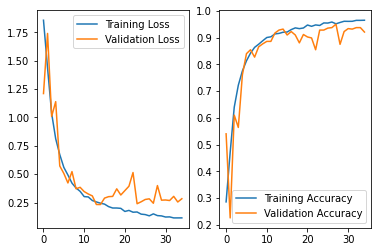

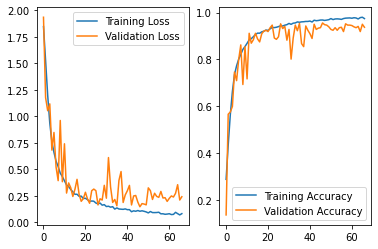

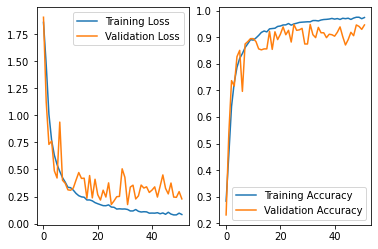

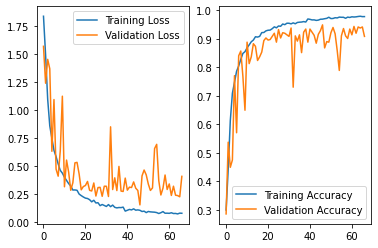

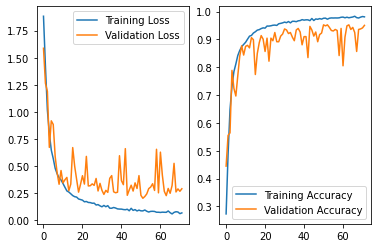

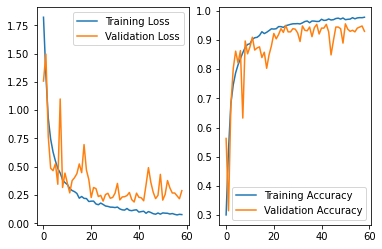

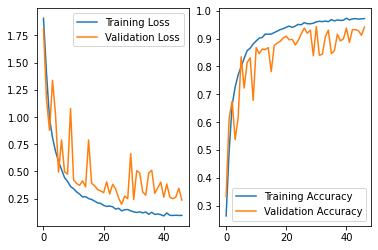

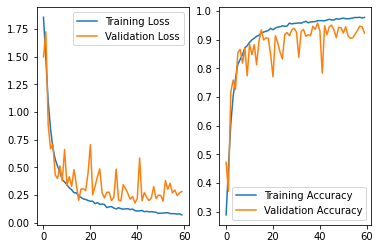

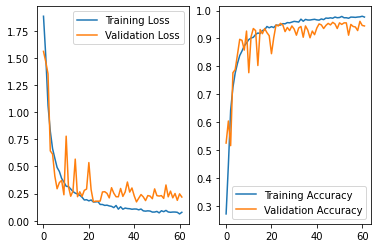

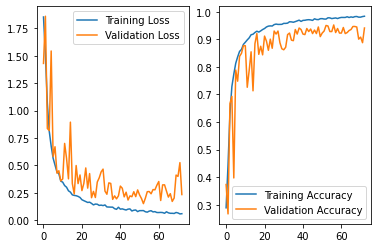

In [27]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [28]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.91512155 0.91011544 0.90951756 0.98407716 0.94023354
 0.72671919 0.92396401]
precision sdev by class [0.         0.06892091 0.09154023 0.05488339 0.00406785 0.04022358
 0.08059381 0.04367519]
macro precision mean 0.9137185558799651
macro precision sdev 0.017732809143408287
recall mean [0.88333333 0.91923077 0.80378788 0.9262069  0.96515403 0.89957265
 0.90064103 0.96280488]
recall sdev [0.23629078 0.07179487 0.0664295  0.04956889 0.00965887 0.05261504
 0.11677404 0.01664087]
macro recall mean 0.9075914325571223
macro recall sdev 0.028770252013419883
f1 mean [0.91666667 0.91594732 0.84981366 0.91577761 0.9745003  0.91806215
 0.79456044 0.9421735 ]
f1 sdev [0.17078251 0.06194585 0.05588123 0.03041989 0.00577302 0.03194157
 0.05423188 0.01992415]
macro f1 mean 0.9034377072613997
macro f1 sdev 0.023602010185351473
accuracy mean 0.9439935314954567
accuracy sdev 0.009714200500490603


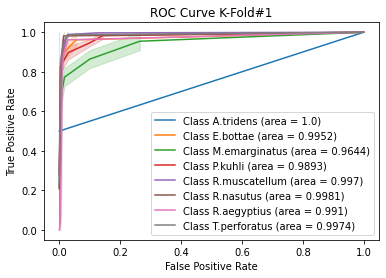

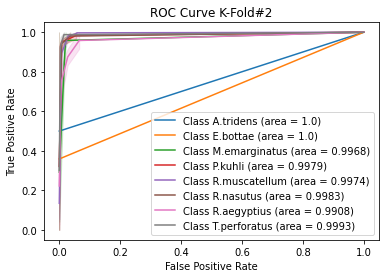

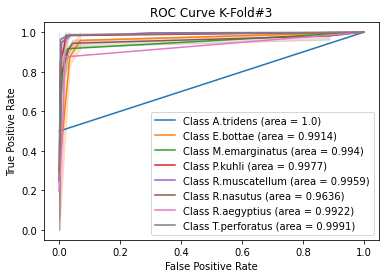

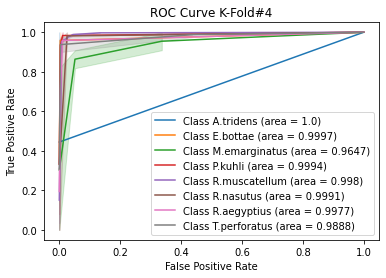

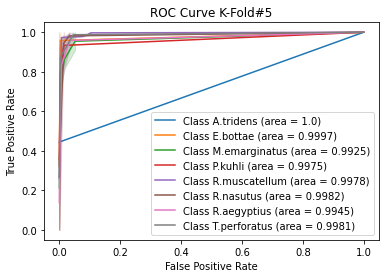

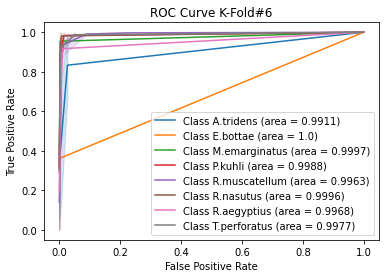

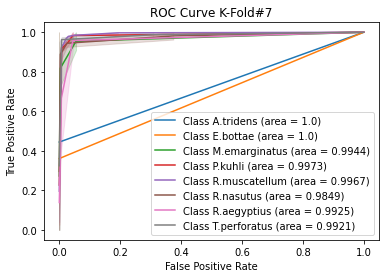

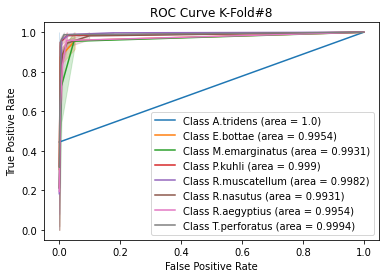

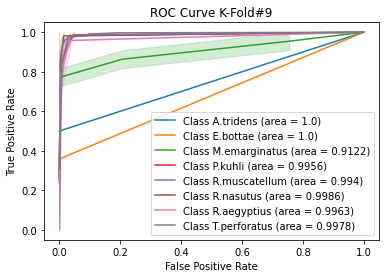

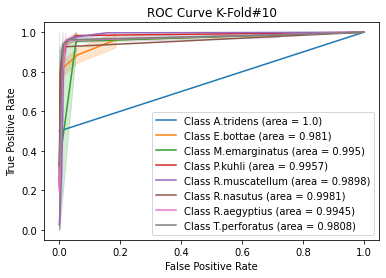

In [29]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [30]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9991081382385729
Std  0.0026755852842809463
Sp:  E.bottae
AUC Mean  0.996245216464388
Std  0.005806991485830697
Sp:  M.emarginatus
AUC Mean  0.9806793135765763
Std  0.02587027600487357
Sp:  P.kuhli
AUC Mean  0.9968153071641999
Std  0.0027904269252155504
Sp:  R.muscatellum
AUC Mean  0.9961238350922377
Std  0.0024015740410367322
Sp:  R.nasutus
AUC Mean  0.993178397586522
Std  0.010712422957366026
Sp:  R.aegyptius
AUC Mean  0.9941780477208827
Std  0.0023196989032285217
Sp:  T.perforatus
AUC Mean  0.9950486221234941
Std  0.005757955849569702


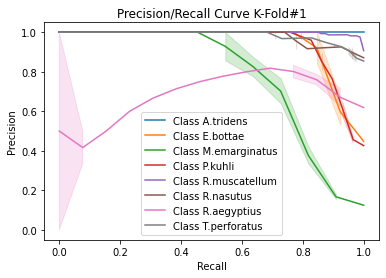

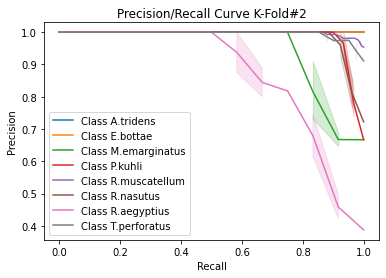

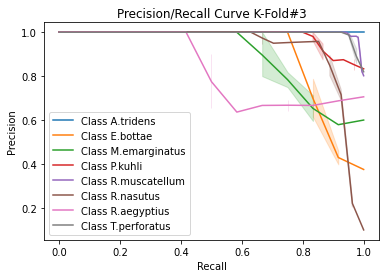

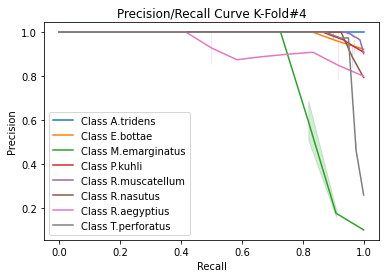

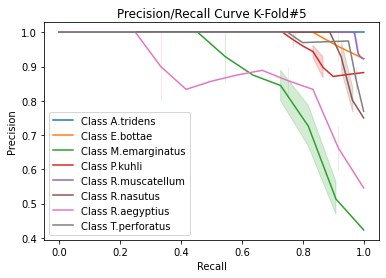

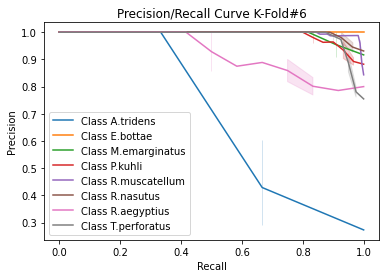

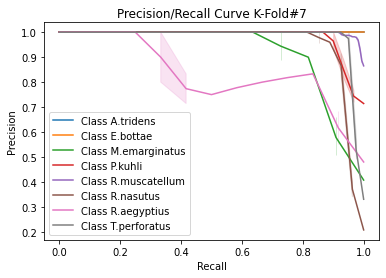

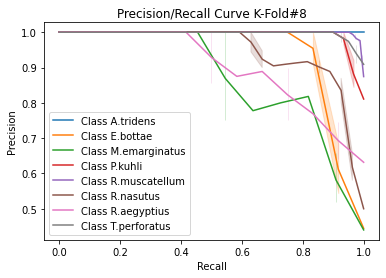

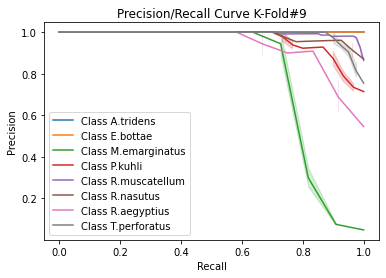

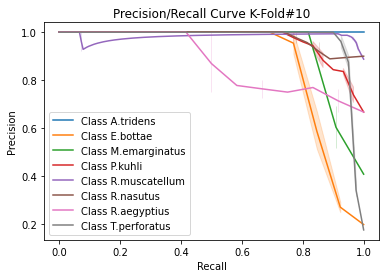

In [31]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  1   0   0   0   0   0   1   0]
 [  0  11   0   0   0   2   0   0]
 [  0   0   8   1   0   0   2   0]
 [  0   0   1  25   2   0   1   0]
 [  0   0   0   1 162   0   0   3]
 [  0   0   0   1   0  25   1   0]
 [  0   1   0   0   0   0  12   0]
 [  0   0   1   0   1   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  10   0   0   0   2   0]
 [  0   0   1  28   1   0   0   0]
 [  0   0   0   0 161   0   2   3]
 [  0   0   0   1   1  23   1   0]
 [  0   0   0   0   1   0  10   1]
 [  0   0   0   0   0   0   1  40]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0   9   0   1   0   2   0]
 [  0   0   0  29   1   0   0   0]
 [  0   1   0   4 159   0   2   0]
 [  0   1   0   0   0  24   2   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   1  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

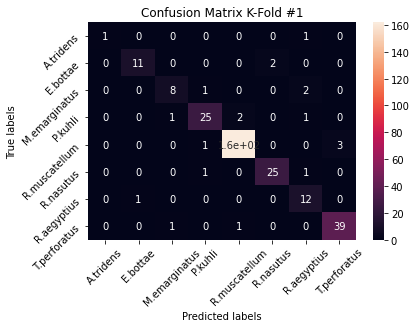

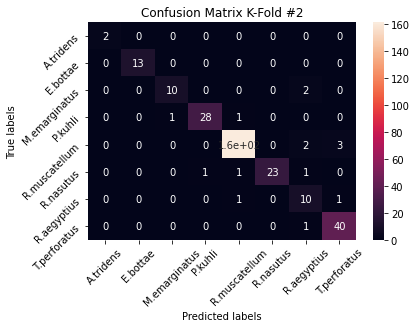

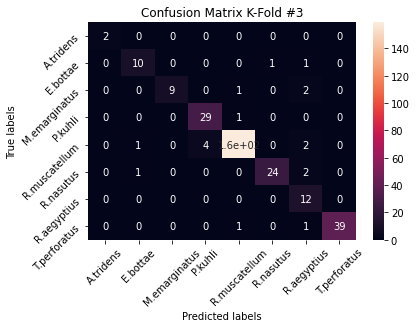

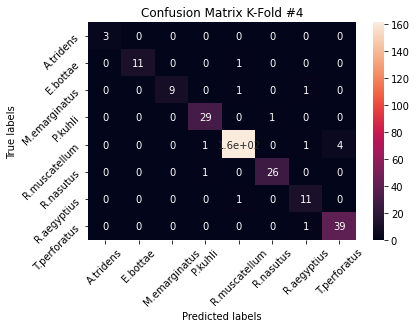

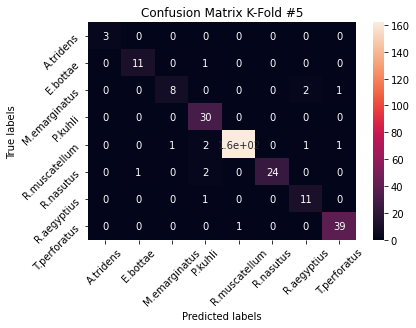

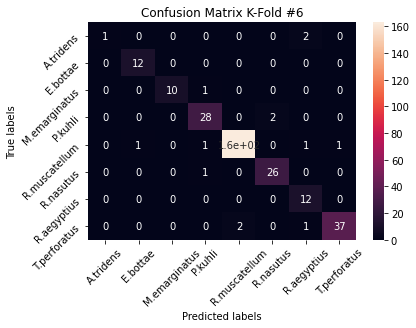

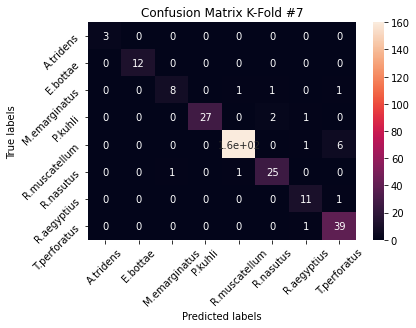

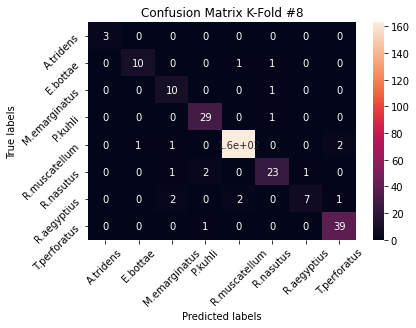

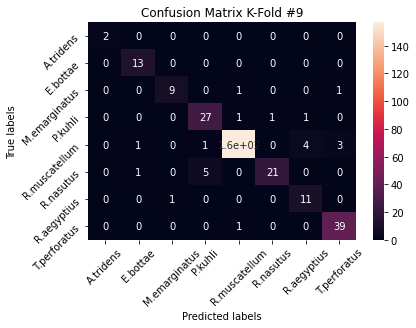

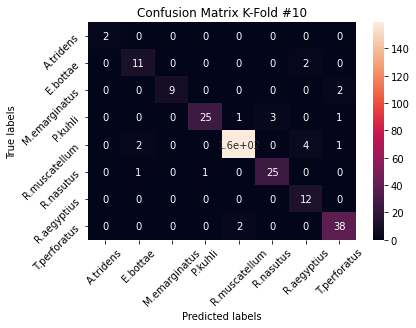

In [32]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  22    0    0    0    0    0    3    0]
 [   0  114    0    1    2    4    3    0]
 [   0    0   90    2    4    2    9    5]
 [   0    0    2  277    6   10    3    1]
 [   0    6    2   10 1607    0   16   24]
 [   0    4    2   14    2  242    5    0]
 [   0    1    3    1    4    0  109    3]
 [   0    0    1    1    8    0    5  388]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  27   0   1   0   0]
 [  0   0   0   1 160   0   1   2]
 [  0   0   0   1   0  24   0   0]
 [  0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0  38]]


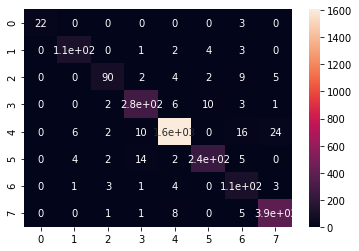

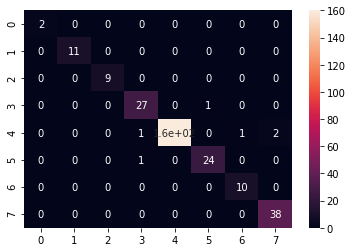

In [33]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.88 0.   0.   0.   0.   0.   0.12 0.  ]
 [0.   0.92 0.   0.01 0.02 0.03 0.02 0.  ]
 [0.   0.   0.8  0.02 0.04 0.02 0.08 0.04]
 [0.   0.   0.01 0.93 0.02 0.03 0.01 0.  ]
 [0.   0.   0.   0.01 0.97 0.   0.01 0.01]
 [0.   0.01 0.01 0.05 0.01 0.9  0.02 0.  ]
 [0.   0.01 0.02 0.01 0.03 0.   0.9  0.02]
 [0.   0.   0.   0.   0.02 0.   0.01 0.96]]


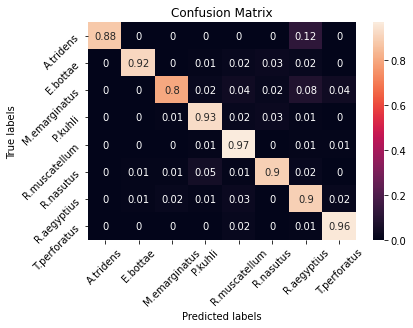

In [34]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V2 !!!!! K-Fold Training and Evaluation</h2>

In [35]:
folder = "models"
mode_version = "spec_RO_v2"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/spec_RO_v2


In [36]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=24,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=136,kernel_size=(7,7),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=120,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(512)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.4)(lay)

    lay = Dense(256)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.3)(lay)

    lay = Dense(128)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.2)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [37]:
model = build_current_model()
model.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 56, 85, 24)        1824      
_________________________________________________________________
batch_normalization_84 (Batc (None, 56, 85, 24)        96        
_________________________________________________________________
activation_84 (Activation)   (None, 56, 85, 24)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 43, 24)        0         
_________________________________________________________________
spatial_dropout2d_48 (Spatia (None, 28, 43, 24)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 22, 56)        336

In [38]:
kFold_train(X_all,Y_all, mode_version)
               

Original training set shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 16s - loss: 1.8802 - acc: 0.2863 - val_loss: 1.7857 - val_acc: 0.5055
Epoch 2/100
9592/9592 - 14s - loss: 1.2865 - acc: 0.5298 - val_loss: 1.0721 - val_acc: 0.5882
Epoch 3/100
9592/9592 - 13s - loss: 0.9083 - acc: 0.6865 - val_loss: 0.9604 - val_acc: 0.6691
Epoch 4/100
9592/9592 - 13s - loss: 0.7101 - acc: 0.7618 - val_loss: 0.8551 - val_acc: 0.7188
Epoch 5/100
9592/9592 - 13s - loss: 0.5657 - acc: 0.8101 - val_loss: 0.5331 - val_acc: 0.8

Epoch 8/100
9592/9592 - 8s - loss: 0.3582 - acc: 0.8829 - val_loss: 0.4438 - val_acc: 0.8382
Epoch 9/100
9592/9592 - 9s - loss: 0.3424 - acc: 0.8833 - val_loss: 0.5672 - val_acc: 0.7684
Epoch 10/100
9592/9592 - 8s - loss: 0.3001 - acc: 0.9051 - val_loss: 0.3416 - val_acc: 0.8879
Epoch 11/100
9592/9592 - 9s - loss: 0.2622 - acc: 0.9148 - val_loss: 0.3284 - val_acc: 0.8897
Epoch 12/100
9592/9592 - 9s - loss: 0.2430 - acc: 0.9217 - val_loss: 0.3069 - val_acc: 0.9044
Epoch 13/100
9592/9592 - 9s - loss: 0.2233 - acc: 0.9270 - val_loss: 0.2639 - val_acc: 0.9173
Epoch 14/100
9592/9592 - 8s - loss: 0.2075 - acc: 0.9338 - val_loss: 0.3294 - val_acc: 0.9118
Epoch 15/100
9592/9592 - 8s - loss: 0.1927 - acc: 0.9379 - val_loss: 0.4113 - val_acc: 0.8438
Epoch 16/100
9592/9592 - 9s - loss: 0.1844 - acc: 0.9412 - val_loss: 0.2299 - val_acc: 0.9338
Epoch 17/100
9592/9592 - 8s - loss: 0.1639 - acc: 0.9487 - val_loss: 0.2325 - val_acc: 0.9338
Epoch 18/100
9592/9592 - 9s - loss: 0.1561 - acc: 0.9495 - val

Epoch 26/100
9592/9592 - 9s - loss: 0.0976 - acc: 0.9701 - val_loss: 0.3018 - val_acc: 0.9136
Epoch 27/100
9592/9592 - 9s - loss: 0.1060 - acc: 0.9658 - val_loss: 0.4669 - val_acc: 0.8695
Epoch 28/100
9592/9592 - 9s - loss: 0.1023 - acc: 0.9679 - val_loss: 0.2335 - val_acc: 0.9228
Epoch 29/100
9592/9592 - 10s - loss: 0.0933 - acc: 0.9719 - val_loss: 0.2447 - val_acc: 0.9320
Epoch 30/100
9592/9592 - 9s - loss: 0.0847 - acc: 0.9753 - val_loss: 0.3002 - val_acc: 0.9191
Epoch 31/100
9592/9592 - 9s - loss: 0.0866 - acc: 0.9741 - val_loss: 0.3040 - val_acc: 0.9283
Epoch 32/100
9592/9592 - 9s - loss: 0.1030 - acc: 0.9675 - val_loss: 0.3379 - val_acc: 0.9173
Epoch 33/100
9592/9592 - 9s - loss: 0.0892 - acc: 0.9733 - val_loss: 0.3816 - val_acc: 0.8934
Epoch 34/100
9592/9592 - 9s - loss: 0.0734 - acc: 0.9768 - val_loss: 0.3229 - val_acc: 0.9228
Epoch 35/100
9592/9592 - 9s - loss: 0.0895 - acc: 0.9719 - val_loss: 0.3469 - val_acc: 0.9062
Epoch 36/100
9592/9592 - 9s - loss: 0.0851 - acc: 0.9731 - 

Epoch 19/100
9584/9584 - 9s - loss: 0.1461 - acc: 0.9518 - val_loss: 0.3306 - val_acc: 0.9026
Epoch 20/100
9584/9584 - 8s - loss: 0.1371 - acc: 0.9575 - val_loss: 0.3048 - val_acc: 0.9173
Epoch 21/100
9584/9584 - 9s - loss: 0.1380 - acc: 0.9554 - val_loss: 0.5554 - val_acc: 0.8438
Epoch 22/100
9584/9584 - 9s - loss: 0.1221 - acc: 0.9628 - val_loss: 0.3067 - val_acc: 0.9026
Epoch 23/100
9584/9584 - 9s - loss: 0.1247 - acc: 0.9593 - val_loss: 0.3172 - val_acc: 0.9118
Epoch 24/100
9584/9584 - 9s - loss: 0.1128 - acc: 0.9650 - val_loss: 0.5291 - val_acc: 0.8346
Epoch 25/100
9584/9584 - 9s - loss: 0.1098 - acc: 0.9689 - val_loss: 0.2534 - val_acc: 0.9246
Epoch 26/100
9584/9584 - 9s - loss: 0.1104 - acc: 0.9662 - val_loss: 0.2537 - val_acc: 0.9118
Epoch 27/100
9584/9584 - 9s - loss: 0.0975 - acc: 0.9708 - val_loss: 0.2680 - val_acc: 0.9301
Epoch 28/100
9584/9584 - 8s - loss: 0.1015 - acc: 0.9671 - val_loss: 0.2967 - val_acc: 0.9301
Epoch 29/100
9584/9584 - 8s - loss: 0.1006 - acc: 0.9680 - v

Epoch 5/100
9584/9584 - 10s - loss: 0.5867 - acc: 0.8031 - val_loss: 1.1576 - val_acc: 0.6324
Epoch 6/100
9584/9584 - 10s - loss: 0.4741 - acc: 0.8471 - val_loss: 0.6784 - val_acc: 0.7537
Epoch 7/100
9584/9584 - 10s - loss: 0.3938 - acc: 0.8708 - val_loss: 0.5279 - val_acc: 0.8438
Epoch 8/100
9584/9584 - 10s - loss: 0.3401 - acc: 0.8884 - val_loss: 0.4408 - val_acc: 0.8548
Epoch 9/100
9584/9584 - 10s - loss: 0.2829 - acc: 0.9086 - val_loss: 0.3505 - val_acc: 0.8842
Epoch 10/100
9584/9584 - 10s - loss: 0.2709 - acc: 0.9131 - val_loss: 0.5594 - val_acc: 0.8272
Epoch 11/100
9584/9584 - 11s - loss: 0.2491 - acc: 0.9175 - val_loss: 0.4776 - val_acc: 0.8529
Epoch 12/100
9584/9584 - 10s - loss: 0.2223 - acc: 0.9277 - val_loss: 0.3596 - val_acc: 0.8750
Epoch 13/100
9584/9584 - 10s - loss: 0.2001 - acc: 0.9316 - val_loss: 0.3050 - val_acc: 0.9136
Epoch 14/100
9584/9584 - 11s - loss: 0.1902 - acc: 0.9394 - val_loss: 0.3825 - val_acc: 0.8750
Epoch 15/100
9584/9584 - 10s - loss: 0.1718 - acc: 0.94

Epoch 32/100
9584/9584 - 9s - loss: 0.0947 - acc: 0.9703 - val_loss: 0.3417 - val_acc: 0.9044
Epoch 33/100
9584/9584 - 10s - loss: 0.0724 - acc: 0.9784 - val_loss: 0.2024 - val_acc: 0.9430
Epoch 34/100
9584/9584 - 10s - loss: 0.0856 - acc: 0.9737 - val_loss: 0.3272 - val_acc: 0.9301
Epoch 35/100
9584/9584 - 9s - loss: 0.0788 - acc: 0.9758 - val_loss: 0.2916 - val_acc: 0.9320
Epoch 36/100
9584/9584 - 9s - loss: 0.0732 - acc: 0.9774 - val_loss: 0.3744 - val_acc: 0.9081
Epoch 37/100
9584/9584 - 10s - loss: 0.0722 - acc: 0.9783 - val_loss: 0.2316 - val_acc: 0.9504
Epoch 38/100
9584/9584 - 9s - loss: 0.0657 - acc: 0.9797 - val_loss: 0.2569 - val_acc: 0.9467
Epoch 39/100
9584/9584 - 10s - loss: 0.0560 - acc: 0.9842 - val_loss: 0.4211 - val_acc: 0.8879
Epoch 40/100
9584/9584 - 10s - loss: 0.0792 - acc: 0.9765 - val_loss: 0.2853 - val_acc: 0.9246
Epoch 41/100
9584/9584 - 10s - loss: 0.0588 - acc: 0.9835 - val_loss: 0.2917 - val_acc: 0.9375
Epoch 42/100
9584/9584 - 9s - loss: 0.0592 - acc: 0.98

Epoch 13/100
9592/9592 - 9s - loss: 0.2130 - acc: 0.9321 - val_loss: 0.6661 - val_acc: 0.7812
Epoch 14/100
9592/9592 - 9s - loss: 0.1957 - acc: 0.9383 - val_loss: 0.3526 - val_acc: 0.8934
Epoch 15/100
9592/9592 - 9s - loss: 0.1714 - acc: 0.9452 - val_loss: 0.5137 - val_acc: 0.8235
Epoch 16/100
9592/9592 - 10s - loss: 0.1669 - acc: 0.9488 - val_loss: 0.6288 - val_acc: 0.7941
Epoch 17/100
9592/9592 - 9s - loss: 0.1424 - acc: 0.9524 - val_loss: 0.3386 - val_acc: 0.9062
Epoch 18/100
9592/9592 - 10s - loss: 0.1587 - acc: 0.9485 - val_loss: 0.2716 - val_acc: 0.9136
Epoch 19/100
9592/9592 - 9s - loss: 0.1346 - acc: 0.9563 - val_loss: 0.4339 - val_acc: 0.8860
Epoch 20/100
9592/9592 - 9s - loss: 0.1242 - acc: 0.9577 - val_loss: 0.3074 - val_acc: 0.9099
Epoch 21/100
9592/9592 - 10s - loss: 0.1329 - acc: 0.9592 - val_loss: 0.3943 - val_acc: 0.9210
Epoch 22/100
9592/9592 - 9s - loss: 0.1171 - acc: 0.9641 - val_loss: 0.2420 - val_acc: 0.9357
Epoch 23/100
9592/9592 - 10s - loss: 0.1092 - acc: 0.9657

In [39]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

File Name Loaded:  models/spec_RO_v2_iter_1.model
File Name Loaded:  models/spec_RO_v2_iter_2.model
File Name Loaded:  models/spec_RO_v2_iter_3.model
File Name Loaded:  models/spec_RO_v2_iter_4.model
File Name Loaded:  models/spec_RO_v2_iter_9.model
File Name Loaded:  models/spec_RO_v2_iter_10.model


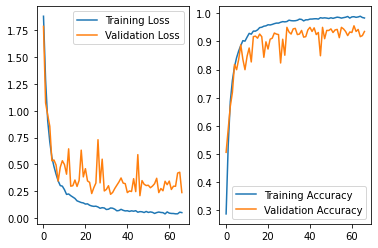

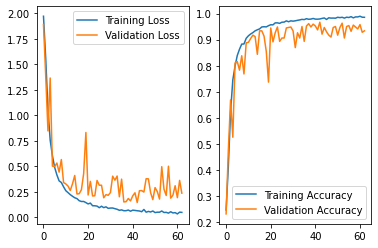

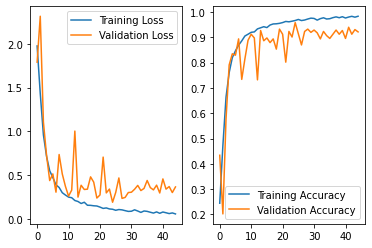

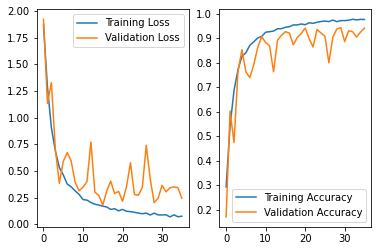

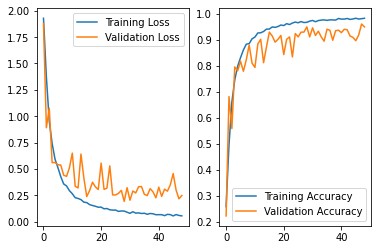

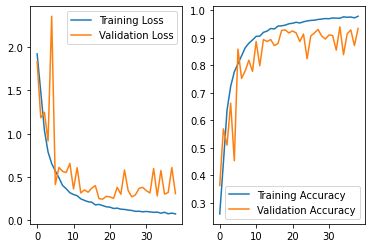

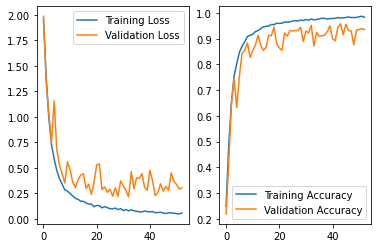

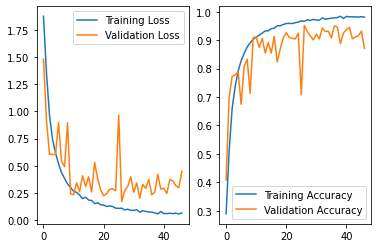

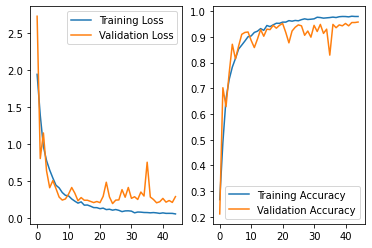

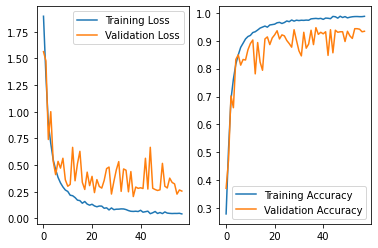

In [40]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [41]:
print_metrics(kFold_metrics)


precision mean by class [1.         0.90545122 0.8644697  0.89710298 0.98123235 0.93097034
 0.71995273 0.94462714]
precision sdev by class [0.         0.08605746 0.14672521 0.07484642 0.01360569 0.04772383
 0.10883295 0.04159899]
macro precision mean 0.9054758072596887
macro precision sdev 0.02493029075715007
recall mean [0.9        0.93653846 0.76893939 0.92287356 0.96394921 0.8997151
 0.91025641 0.9354878 ]
recall sdev [0.21343747 0.06906735 0.10525942 0.03739591 0.01789249 0.08445552
 0.07486565 0.04313679]
macro recall mean 0.9047199929449393
macro recall sdev 0.03171222107139596
f1 mean [0.93       0.9189693  0.80290972 0.90765255 0.9723797  0.91182957
 0.79581186 0.93877849]
f1 sdev [0.15524175 0.06765569 0.08353303 0.0397537  0.01122508 0.04777209
 0.05411422 0.0257988 ]
macro f1 mean 0.8972913999200269
macro f1 sdev 0.02838624316601013
accuracy mean 0.9390167433059778
accuracy sdev 0.015562937080065316


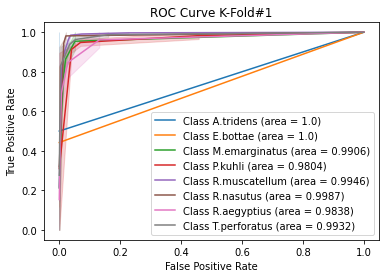

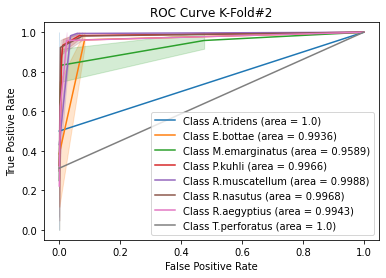

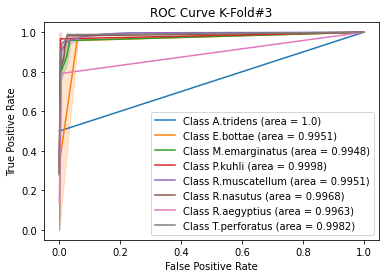

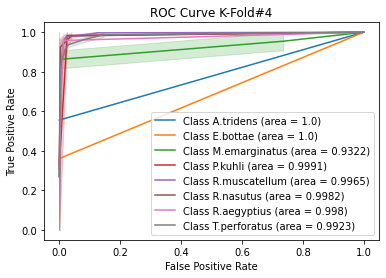

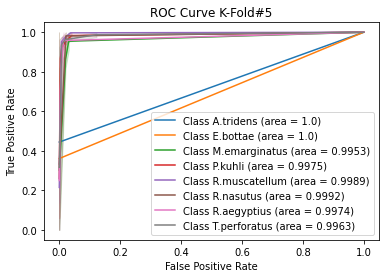

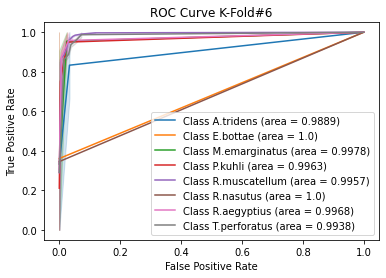

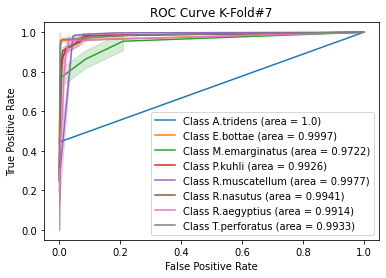

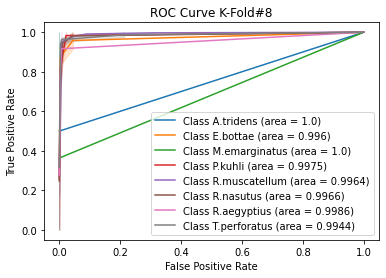

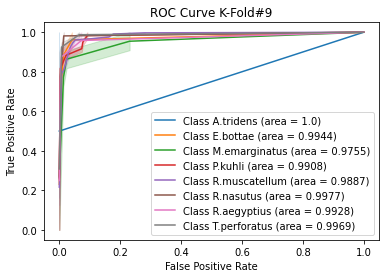

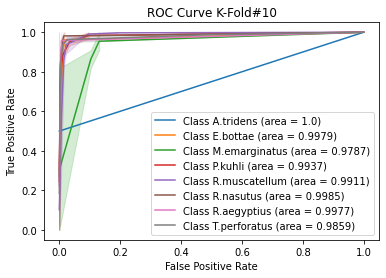

In [42]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [43]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


Sp:  A.tridens
AUC Mean  0.9988851727982162
Std  0.003344481605351157
Sp:  E.bottae
AUC Mean  0.9976670795613195
Std  0.0025007885109313266
Sp:  M.emarginatus
AUC Mean  0.9796127557121158
Std  0.020234786740659053
Sp:  P.kuhli
AUC Mean  0.9944458035717542
Std  0.005398450146340463
Sp:  R.muscatellum
AUC Mean  0.9953676325198254
Std  0.003097326119335582
Sp:  R.nasutus
AUC Mean  0.997657908865938
Std  0.001591971804678239
Sp:  R.aegyptius
AUC Mean  0.9946949219694119
Std  0.004284384459192908
Sp:  T.perforatus
AUC Mean  0.9944295246716616
Std  0.0036797413634905842


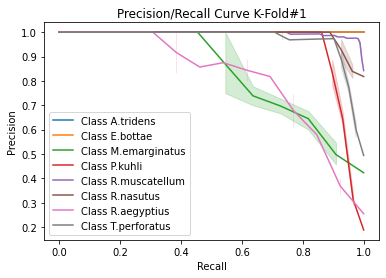

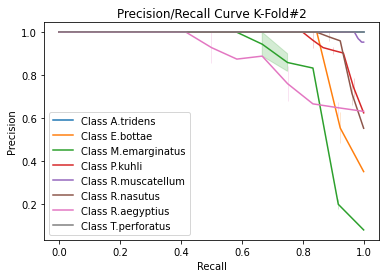

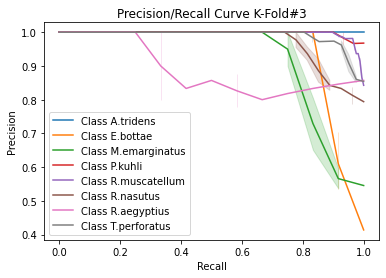

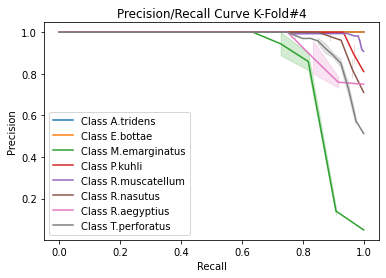

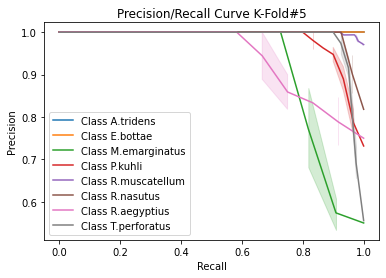

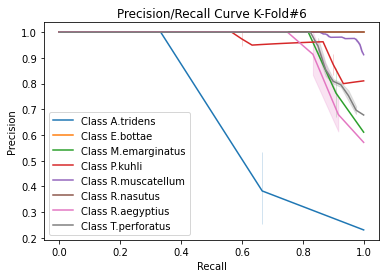

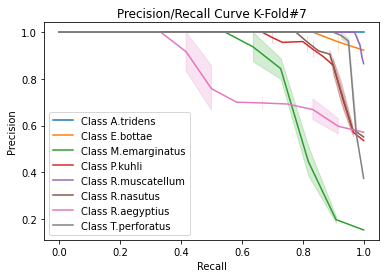

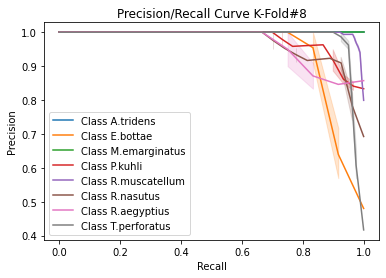

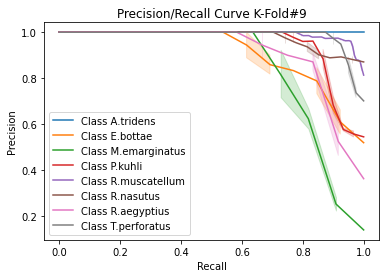

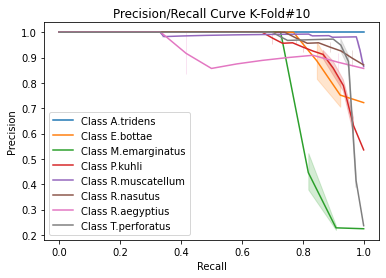

In [44]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   7   0   1   1   2   0]
 [  0   0   1  25   2   1   0   0]
 [  0   0   1   0 164   0   1   0]
 [  0   0   0   0   1  25   1   0]
 [  0   0   1   0   1   0  10   1]
 [  0   0   1   0   3   0   1  36]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0   8   2   0   0   2   0]
 [  0   0   0  29   0   1   0   0]
 [  0   0   0   0 162   0   4   0]
 [  0   0   0   1   0  24   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0   9   0   1   0   2   0]
 [  0   0   0  27   2   1   0   0]
 [  0   0   0   0 161   2   2   1]
 [  0   0   0   0   1  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   1   0   0   1   1  38]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

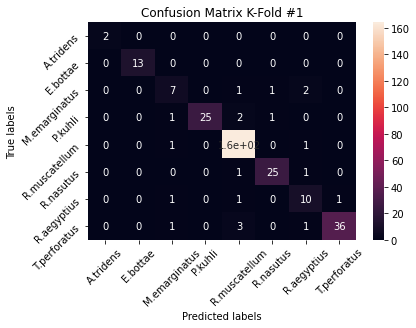

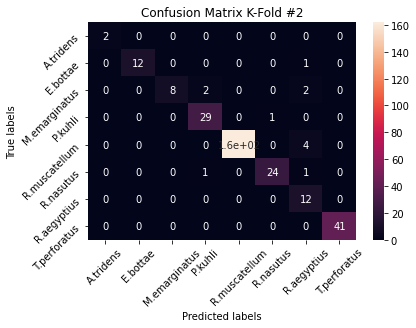

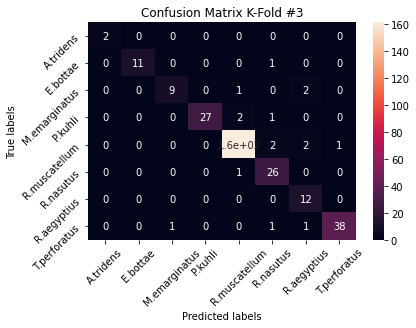

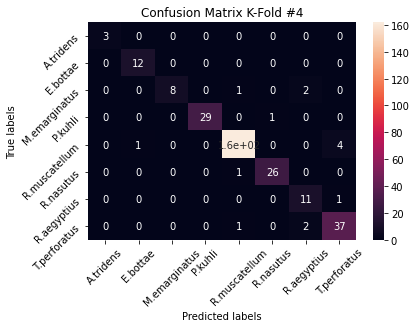

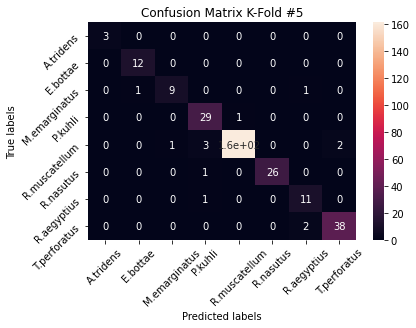

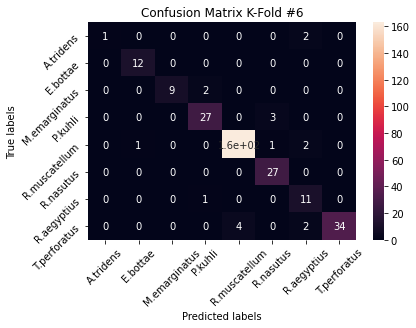

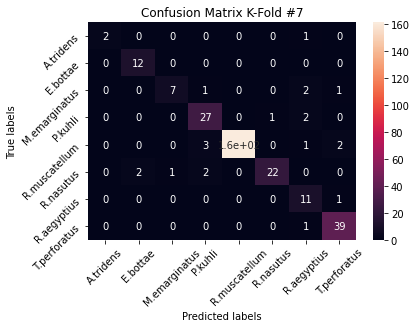

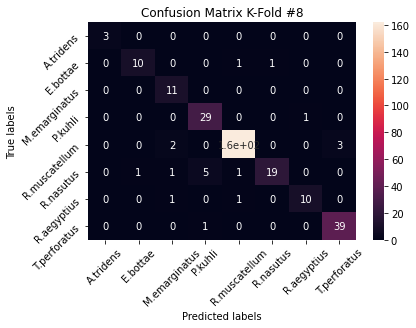

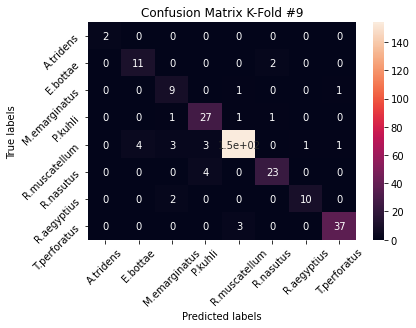

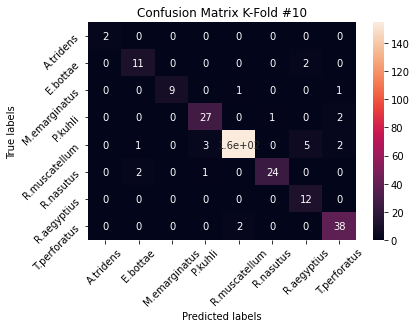

In [45]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


sum of all confuion matrices
 [[  22    0    0    0    0    0    3    0]
 [   0  116    0    0    1    4    3    0]
 [   0    1   86    5    5    1   11    3]
 [   0    0    2  276    6   10    3    2]
 [   0    7    7   12 1605    3   16   15]
 [   0    5    2   14    4  242    2    0]
 [   0    0    4    2    2    0  110    3]
 [   0    0    2    1   13    1    9  377]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   8   0   0   0   1   0]
 [  0   0   0  27   0   1   0   0]
 [  0   0   0   1 160   0   1   1]
 [  0   0   0   1   0  24   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  37]]


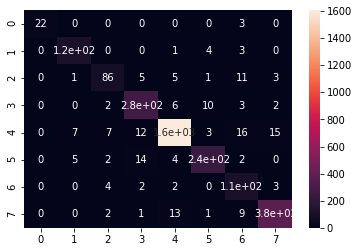

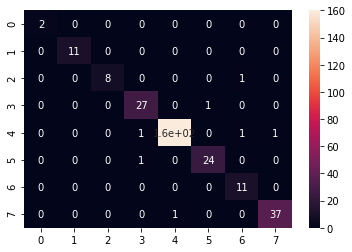

In [46]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


[[0.88 0.   0.   0.   0.   0.   0.12 0.  ]
 [0.   0.94 0.   0.   0.01 0.03 0.02 0.  ]
 [0.   0.01 0.77 0.04 0.04 0.01 0.1  0.03]
 [0.   0.   0.01 0.92 0.02 0.03 0.01 0.01]
 [0.   0.   0.   0.01 0.96 0.   0.01 0.01]
 [0.   0.02 0.01 0.05 0.01 0.9  0.01 0.  ]
 [0.   0.   0.03 0.02 0.02 0.   0.91 0.02]
 [0.   0.   0.   0.   0.03 0.   0.02 0.94]]


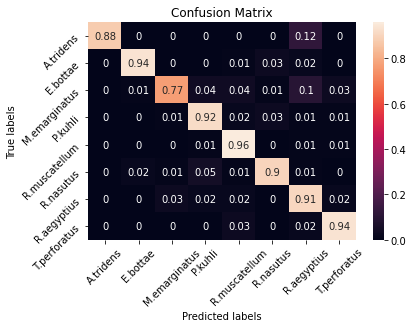

In [47]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V3 !!!!! K-Fold Training and Evaluation</h2>

In [ ]:
folder = "models"
mode_version = "spec_RO_v3"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

In [13]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=176,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=144,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(144)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(96)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
model = build_current_model()
model.summary()

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V4 !!!!! K-Fold Training and Evaluation</h2>

In [ ]:
folder = "models"
mode_version = "spec_RO_v4"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

In [35]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=160,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=112,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=80,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(256)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(448)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(352)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [ ]:
model = build_current_model()
model.summary()

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

<h2> V5 !!!!! K-Fold Training and Evaluation</h2>

In [ ]:
folder = "models"
mode_version = "spec_RO_v5"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

In [49]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=48,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(112)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(32)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
model = build_current_model()
model.summary()

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)

# V6 Re-Load Data

In [ ]:
folder = "models"
mode_version = "spec_RO_v6"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

In [63]:
X_all = []
Y_all = []

image_folder_path = '../../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((85, 56))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [64]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 56, 85, 3)
(3018,)


In [65]:
def build_current_model():
    inp = Input(shape=(56,85,3))
    lay = Convolution2D(filters=168,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.2)(lay)

    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=232,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=104,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.4)(lay)

    lay = Flatten()(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [ ]:
model = build_current_model()
model.summary()

In [ ]:
kFold_train(X_all,Y_all, mode_version)
               

In [ ]:
kFold_metrics=kFold_test(X_all,Y_all, mode_version)

In [ ]:
# print(KFold_metrics.get("all_df"))
plot_loss_Accuracy(kFold_metrics.get("all_df"))

In [ ]:
print_metrics(kFold_metrics)


In [ ]:
plot_ROC(kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
print_meanAUC (kFold_metrics.get("all_fpr"),kFold_metrics.get("all_tpr"))


In [ ]:
plot_precision_recall(kFold_metrics.get("all_recall"),kFold_metrics.get("all_precision"))
                   

In [ ]:
plot_confusion_matrices_per_iter(kFold_metrics.get("all_cm"))


In [ ]:
sum_all_cm, avg_all_cm=plot_macro_confusion_matrices(kFold_metrics.get("all_cm"))                   


In [ ]:
plot_normalised_confusion_matrix(sum_all_cm, avg_all_cm)